In [1]:
include("notebook_preamble.jl");

# Computation of jump operators

In [3]:
const σ0 = [1 0; 0 1];
const σx = [0 1; 1 0];
const σy = [0 -im; im 0];
const σz = [1 0; 0 -1];
const σp = [0 1; 0 0];
const σm = [0 0; 1 0];

H_to_spindim(H) = Int(log2(size(H)[1]))
⊗ₖ(a, b) = kron(b, a);
function siteop(A, i, n)
    i = i > 0 ? 1 + ((i - 1) % n) : throw(ArgumentError("Site index must be positive."))
    ops = repeat([one(A)], n)
    ops[i] = A
    reduce(⊗ₖ, ops)
end;

In [4]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
dictmap(f, dict) = Dict(key => f(value) for (key, value) in dict)
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

sumprojector(A) = sum(a * a' for a in A)
projectors(eigdict) = dictmap(sumprojector, eigdict);

function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(one(eltype(J)) * N)*J for (J, N) in d]
end;

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)
function jumps(vals, vecs, As; combine=true, isequal=isequalto())
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict), E2 in keys(eigendict)),
        isequal=isequal)
    Πs = projectors(eigendict)
    Jωs = dictmap(ωs) do ΔEs
        filter(x -> !isequal(x, zero(x)),
            [sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs) for A in As])
    end
    combine ? dictmap(combinejumps, Jωs) : Jωs
end

dipole_interactions(n) = vcat(map(A -> [siteop(A, i, n) for i in 1:n], [σx, σy, σz])...)
function dipolejumps(H; kwargs...)
    vals, vecs = eigen(H)
    jumps(vals, eachcol(vecs), dipole_interactions(H_to_spindim(H)); kwargs...)
end;

# Dissipator eigenvalue plots

In [5]:
leftmul(A)  = one(A) ⊗ₖ A
rightmul(A) = permutedims(A) ⊗ₖ one(A)
comm(A, B) = A*B - B*A
acomm(A, B) = A*B + B*A
commwith(A) = leftmul(A) - rightmul(A)
acommwith(A) = leftmul(A) + rightmul(A);

In [6]:
nB(ω, β) = 1 / (exp(β*ω) - 1)
γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^3 * (nB(ω, β) + 1)
# γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^2 # High temperature approx.
ℋLSterm(J, S) = S * commwith(J' * J)
ℋLS(Jωs, S; params...) = -im * sum(ℋLSterm(J, S(ω; params...)) for (ω, Js) in Jωs for J in Js)
𝒟term(J, γ) = γ * (leftmul(J) * rightmul(J') - acommwith(J' * J) / 2)
𝒟(Jωs, γ; params...) = sum(𝒟term(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟LRterm(J, γ) = γ * (leftmul(J) * rightmul(J'))
𝒟LR(Jωs, γ; params...) = sum(𝒟LRterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟Aterm(J, γ) = γ * (- acommwith(J' * J) / 2)
𝒟A(Jωs, γ; params...) = sum(𝒟Aterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);

In [7]:
function dissipation_rates(H, γ; params...)
    Jωs = dipolejumps(H)
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

In [8]:
function ηenergyvariance(H, η)
    Es = eigvals(H) / η
    Z = sum(exp(-E) for E in Es)
    Ps = [exp(-E) / Z for E in Es]
    H1 = sum(E * P for (E, P) in zip(Es, Ps))
    H2 = sum(E^2 * P for (E, P) in zip(Es, Ps))
    H2 - H1^2
end;

We map $E \mapsto E / \eta$ so that $\eta$ is a dimensionless inverse temperature $\beta$.

In [9]:
using Roots

In [10]:
trnorm(A) = √(tr(A'*A))
trnormalize(A) = A / trnorm(A)
∠(A, B) = acos(trnorm(trnormalize(A)' * trnormalize(B)))
function slerp(A, B, g)
    θ = ∠(A, B)
    (sin((1-g)*θ)*A + sin(g*θ)*B) / sin(θ)
end

# Requirement: `normslerp` must not change the reference Hamiltonian.
function normslerp(A, B, g)
    C = slerp(A, B, g)
    C /= trnorm(C)
end

Ainvar(g, H0) = find_zero(A -> ηenergyvariance(H0(0), 1) - ηenergyvariance(H0(g), 1/A), 1)
function Hinterp(H1, H2)
    H0(g) = normslerp(trnormalize(H1), trnormalize(H2), g)
    g -> Ainvar(g, H0) * H0(g)
end

function plot_interp_rates(H1, H2, g0s; kwargs...)
    β = 1.0
    H = Hinterp(H1, H2)
    rates_ising = [real(dissipation_rates(H(g), γdiv, β = β)) for g in g0s]
    rates_free_ising = real(dissipation_rates(H(0), γdiv, β = β));
    rates_free_trans = real(dissipation_rates(H(1), γdiv, β = β));

    plot(g0s, -hcat(rates_ising...)',
        xlabel=L"Relative angle $g$",
        ylabel="Relative dissipator eigenvalues (negated)",
        color=:black,
        alpha=0.25,
        key=false;
        kwargs...)

    scatter!(repeat([g0s[1] - 2e-2], length(rates_free_ising)), -rates_free_ising,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    scatter!(repeat([g0s[end] + 2e-2], length(rates_free_trans)), -rates_free_trans,
        marker=(:ltriangle, 2, rubric),
        markerstrokecolor=rubric
    )
end;

In [11]:
η0s = 10 .^ range(-1, 1.5, length=128)
βs = [1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0, 1e1, 2e1, 5e1];

The Ising interaction and transverse-field Hamiltonians are

In [12]:
Hx(n) = -sum(siteop(σx, i, n) * siteop(σx, i+1, n) for i in 1:n)
Hz(n) = -sum(siteop(σz, i, n) for i in 1:n);

Convenient slerp:

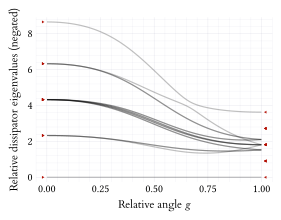

In [13]:
plot_interp_rates(Hx(2), Hz(2), range(1e-3, 1-1e-3, length=64))

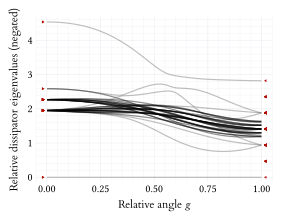

In [14]:
plot_interp_rates(Hx(3), Hz(3), range(1e-3, 1-1e-3, length=64))

In [15]:
Hp = Hinterp(Hx(4), Hz(4));

In [16]:
lgs = range(1e-3, 1-1e-3, length=64)
energies = [eigvals(Hp(g)) for g in lgs]
Hnorms = [trnorm(Hp(g))^2 for g in lgs]
energydifferences = [[x - y for (x, y) in Iterators.product(Es, Es)] for Es in energies];

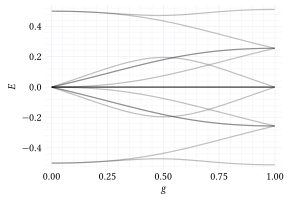

In [17]:
plot(lgs, hcat(energies...)', color=:black, alpha=0.25, key=false, xlabel=L"g", ylabel=L"E")

# Explicit simulation

`QuantumOptics` simulation

In [72]:
g = 0.5
n = 4
b = SpinBasis(1//2)
sys = ⊗(repeat([b], n)...)
Hsys = Hinterp(Hx(n), Hz(n))(g)
Jωs = dipolejumps(Hsys)
η = 1e0 # η = τB/τS ~ β.
α = 1e-2 # Modifies amplitudes of γ and S due to vacuum timescale. √α = τ0 / τS.
Ω = 1e1 * maximum(keys(Jωs))
jumpops, rates = [], Float64[]
for (ω, Js) in Jωs
    for J in Js
        push!(rates, α * (1e-1 < η*ω ? ω^3 * (1 + 1 / (exp(η*ω) - 1)) : ω^2 / η))
        push!(jumpops, DenseOperator(sys, J))
    end
end
lambham = -α * (Ω / π) * sum(ω * J' * J for (ω, Js) in Jωs for J in Js);

In [73]:
σzm = dense(embed(sys, 1, sigmaz(b)))
function fout(t, ρ)
    ρ = normalize(ρ)
    real(expect(σzm, ρ))
end
Hspin = DenseOperator(sys, Hsys)
Hopen = DenseOperator(sys, Hsys + lambham)
σzth = fout(0.0, thermalstate(Hspin, 1e0))
tf = 5e2
ts = range(0.0, tf, length=501);

In [74]:
up = spinup(b)
ψ0 = ⊗(repeat([up], n)...)
ρ0 = projector(ψ0)
_, fouts0 = timeevolution.schroedinger(ts, ψ0, Hspin; fout=fout)
_, fouts1 = timeevolution.schroedinger(ts, ψ0, Hopen; fout=fout)
_, fouts = timeevolution.master(ts, ρ0, Hopen, jumpops; rates=rates, fout=fout)
_, foutsd = timeevolution.master(ts, ρ0, 0*Hspin, jumpops; rates=rates, fout=fout);

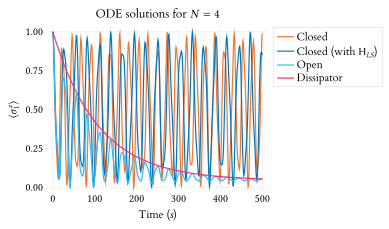

In [75]:
plot(
    title=L"ODE solutions for $N = %$n$",
    xlabel=L"Time ($s$)",
    ylabel=L"\ev{\pauli_1^z}",
)
plot!(ts, [fouts0 fouts1 fouts foutsd], label=["Closed" L"Closed (with $\ham_{LS}$)" "Open" "Dissipator"])

In [76]:
ℒ = steadystate.liouvillian(Hopen, jumpops; rates=rates);

The adjoint Liouvillian can be found by taking the adjoint of the matrix for $\liou$. This has the same spectrum as $\liou$.

In [77]:
ℒspectrum = steadystate.liouvillianspectrum(ℒ; nev=length(ℒ.basis_r[1])*length(ℒ.basis_r[2]))
𝒟rates = real(ℒspectrum[1])

256-element Vector{Float64}:
 -5.437082994124187e-17
 -0.0025758872208938746
 -0.0042728938862623125
 -0.004779144078091269
 -0.0052815499531312085
 -0.0054651115197235055
 -0.005637781861934381
 -0.0056577350326892486
 -0.005673098606317512
 -0.005673098606317545
 -0.005673098606317558
 -0.005673098606317581
 -0.0057483516974672156
  ⋮
 -0.009270509068955839
 -0.009270509068955943
 -0.010898389301190628
 -0.01089838930119041
 -0.013672627379254662
 -0.013672627379255045
 -0.012884878114933798
 -0.012884878114933713
 -0.013021409334939428
 -0.01302140933493911
 -0.012233660070617988
 -0.012233660070617991

In [78]:
coeffs = hcat([vec(V.data) for V in ℒspectrum[2]]...) \ vec(ρ0.data);
sort(abs.(coeffs))

256-element Vector{Float64}:
 7.737663116603245e-18
 2.2966197205709517e-17
 2.3144124238619078e-17
 2.5946747360516818e-17
 3.1687235499861375e-17
 3.283329809066712e-17
 3.462946264400099e-17
 3.491275477602197e-17
 3.560064596185455e-17
 3.885893528708708e-17
 4.031858477224953e-17
 4.2151997860226475e-17
 4.2189116826709664e-17
 ⋮
 0.12163224087045059
 0.12163224087051544
 0.13286034785068604
 0.14401093495892692
 0.14401093495892733
 0.1687690160563168
 0.2457732453850871
 0.2518741264493694
 0.3275383013541788
 0.3767585500358453
 0.4151989029406231
 0.41519890294063894

In [79]:
eigenexpectations = [tr(σzm * V) for V in ℒspectrum[2]]
contributors = @. (abs(eigenexpectations) > 1e-9) & (abs(coeffs) > 1e-9)
weightedrate = -real(sum(@. abs2(coeffs) * ℒspectrum[1]) ./ sum(abs2, coeffs))

0.00951119103811031

Note that the eigenoperators are not orthogonal.

In [80]:
sum(abs, [tr(V1' * V2) for V1 in ℒspectrum[2], V2 in ℒspectrum[2]] - Matrix(1.0I, 4^n, 4^n))

42.17147711938431

In [81]:
using LsqFit

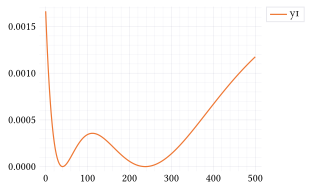

In [82]:
@. decay_exponential(x, p) = p[1]*exp(-x*p[2])
p0 = [1.0, 1e-4]
fit = curve_fit(decay_exponential, ts, foutsd, p0)
plot(ts, (foutsd .- decay_exponential(ts, fit.param)) .^ 2)

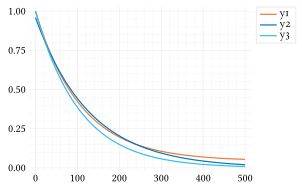

In [83]:
plot(ts, [1.0*foutsd decay_exponential(ts, fit.param) decay_exponential(ts, [1.0, weightedrate])])

In [84]:
fit.param

2-element Vector{Float64}:
 0.9592182019264217
 0.007735461868792747

# Spaghetti

In [85]:
using KernelDensity

Typical inverse frequency differences are on the order of the system time. Even the higher differences (not shown) are well below the relaxation time.

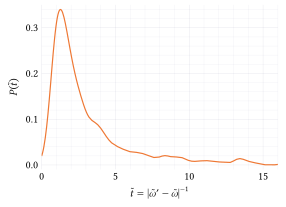

In [86]:
ωkde = kde([1 / abs(ω2 - ω1) for ω1 in keys(Jωs) for ω2 in keys(Jωs) if ω1 ≉ ω2]);
plot(x -> pdf(ωkde, x), xlim=(0, 2^n), key=false, xlabel=L"\tilde{t} = \abs{\tilde{\omega}' - \tilde{\omega}}^{-1}", ylabel=L"P(\tilde{t})")

In [87]:
using ThreadsX

In [88]:
α = 1e-2 # Modifies amplitudes of γ and S due to vacuum timescale. α = τ0 / τB τS.
Ω0 = 1e1
g = 0.25
n = 2
b = SpinBasis(1//2)
sys = ⊗(repeat([b], n)...)
up = spinup(b)
ψ0 = ⊗(repeat([up], n)...)
ρ0 = projector(ψ0)
σzm = dense(embed(sys, 1, sigmaz(b)))
Hint = Hinterp(Hx(n), Hz(n));

In [89]:
function 𝒟_rates(H, n = H_to_spindim(H); η=1.0, ρ0, op)
    Jωs = dipolejumps(H)
    sys = ρ0.basis_r
    jumpops, rates = [], Float64[]
    for (ω, Js) in Jωs
        for J in Js
            push!(rates, 1e-1 < η*ω ? ω^3 * (1 + 1 / (exp(η*ω) - 1)) : ω^2 / η)
            push!(jumpops, DenseOperator(sys, J))
        end
    end
    # No Hamiltonian needed if we are only interested in the dissipator.
    𝒟 = steadystate.liouvillian(DenseOperator(sys), jumpops; rates=rates);
    𝒟rates, 𝒟ops = steadystate.liouvillianspectrum(𝒟; nev=4^n)
    c = hcat([vec(V.data) for V in 𝒟ops]...) \ vec(ρ0.data)
    eigenexpectations = [tr(op * V) for V in 𝒟ops]
    weightedrate = real(sum(abs2.(c) .* 𝒟rates) ./ sum(abs2, c))
    sort(real(𝒟rates)), weightedrate
end;

In [127]:
function plot_𝒟_rates(Hint, g0s; η=1.0, ρ0, op, kwargs...)
    outs = ThreadsX.map(g -> 𝒟_rates(Hint(g); η, ρ0, op), g0s)
    rates = [o[1] for o in outs]
    r0 = [o[2] for o in outs]
    rates0 = 𝒟_rates(Hint(0); η, ρ0, op)[1]
    rates1 = 𝒟_rates(Hint(1); η, ρ0, op)[1]

    plot(g0s, -hcat(rates...)',
        title=L"\eta = %$η",
        xlabel=L"Relative angle $g$",
        ylabel="Relative dissipator eigenvalues (negated)",
        color=:black,
        alpha=0.25,
        key=false;
        kwargs...)

    scatter!(repeat([g0s[1] - 2e-2], length(rates0)), -rates0,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    scatter!(repeat([g0s[end] + 2e-2], length(rates1)), -rates1,
        marker=(:ltriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    plot!(g0s, -r0, color=rubric)
end;

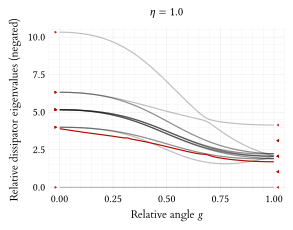

In [130]:
plot_𝒟_rates(Hint, range(1e-3, 1-1e-3, length=64); η=1e0, ρ0, op=σzm)

In [121]:
resolution = 32
g0s = range(1e-3, 1-1e-3, length=resolution)
ηs = range(-2, 2, length=resolution)
gridrates = ThreadsX.map(p -> 𝒟_rates(Hint(p[1]); η=10^(p[2]), ρ0, op=σzm), Iterators.product(g0s, ηs));

In [122]:
ratetensor = Array{Float64}(undef, (length(g0s), length(ηs), 4^n))
for i in eachindex(g0s), j in eachindex(ηs)
    ratetensor[i, j, :] = gridrates[i, j][1]
end
oprates = [x[2] for x in gridrates];

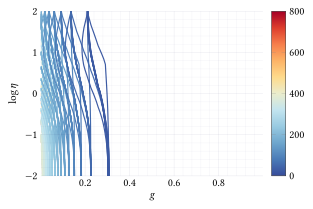

In [123]:
# Disregard noisy zero rate.
plot(g0s, ηs, collect(eachslice(-ratetensor[:, :, 1:end-1], dims=3)),
    st=:contour,
    xlabel=L"g",
    ylabel=L"\log\eta",
    zlabel="Decay rate",
)

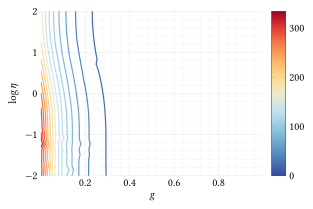

In [124]:
plot(g0s, ηs, -oprates,
    st=:contour,
    xlabel=L"g",
    ylabel=L"\log\eta",
    zlabel="Decay rate",
)